In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# Atoms
from ase.io import read
from ase.geometry import distance

# ML
from regression import SparseKRR
from kernels import build_kernel, linear_kernel, gaussian_kernel
from split import simple_split

# Utilities
from tools import load_json
from selection import FPS, random_selection
from kernels import sqeuclidean_distances
import multiprocessing
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
from sklearn.svm import LinearSVC
import itertools
import h5py
import glob
import project_utils as utils
from tqdm.notebook import tqdm

# Plotting
import matplotlib.pyplot as plt

# SOAP
from soap import quippy_soap, librascal_soap

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle
line_list = cosmostyle.linestyle_cycle

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


# Initial setup

In [3]:
# Setup SOAP parameters
soap_hyperparameters = dict(max_radial=12,
                            max_angular=9,
                            interaction_cutoff=6.0,
                            cutoff_smooth_width=0.3,
                            gaussian_sigma_constant=0.3)

# Check DEEM database energies vs. GULP shell-only optimization for the full 330k structures

In [12]:
deem_10k_energies = np.loadtxt('../Raw_Data/GULP/DEEM_10k/Energies_DEEM.dat', usecols=8)

In [13]:
deem_10k_idxs = np.loadtxt('../Processed_Data/DEEM_330konDEEM_10k/deem_10k.idxs', dtype=int)

## CONV

In [14]:
deem_330k_energies = np.loadtxt('../Raw_Data/GULP/DEEM_330k/optimization_summary_fix.dat', usecols=(1, 2))
errors_330k_energies = deem_330k_energies[:, 1] - deem_330k_energies[:, 0]
stdev_errors_330k_energies = np.std(errors_330k_energies)
mean_errors_330k_energies = np.mean(errors_330k_energies)

In [15]:
errors_10k_330k_energies = deem_330k_energies[deem_10k_idxs][:, 1] - deem_10k_energies
stdev_errors_10k_330k_energies = np.std(errors_10k_330k_energies)
mean_errors_10k_330k_energies = np.mean(errors_10k_330k_energies)

In [16]:
print(np.amax(errors_10k_330k_energies), np.amin(errors_10k_330k_energies))
print(np.amax(np.abs(errors_10k_330k_energies)), np.amin(np.abs(errors_10k_330k_energies)))
print(np.mean(errors_10k_330k_energies), stdev_errors_10k_330k_energies)

8.428580170570058 -0.008756805687880842
8.428580170570058 2.999369826284237e-06
0.006106177898905844 0.1565590484132705


In [17]:
np.argmax(errors_10k_330k_energies) + 8000001

8003638

In [18]:
errors_330k_energies[3637], errors_10k_330k_energies[3637]

(0.08811948000038683, 8.428580170570058)

In [19]:
print(np.amax(errors_330k_energies), np.amin(errors_330k_energies))
print(np.amax(np.abs(errors_330k_energies)), np.amin(np.abs(errors_330k_energies)))
print(np.mean(np.abs(errors_330k_energies)), stdev_errors_330k_energies)
print(np.median(np.abs(errors_330k_energies)))

436.12611450000077 -1.8610915899989777
436.12611450000077 1.4989998817327432e-05
0.07801720125550962 0.8910729420300921
0.07376848500007327


In [20]:
np.argmax(np.abs(errors_330k_energies))

265045

In [21]:
gnorms = np.loadtxt('../Raw_Data/GULP/DEEM_330k/optimization_summary_fix.dat', usecols=3)
failures = np.loadtxt('../Raw_Data/GULP/DEEM_330k/optimization_summary_fix.dat', usecols=(4, 5), dtype=int)

In [22]:
# Failed structures
failed_idxs = np.nonzero(failures[:, 1])[0]
print(failed_idxs)

# Failed optimizations
failed_min_idxs = np.nonzero(failures[:, 0])[0]
print(failed_min_idxs)

[]
[    20    179    208    260   1062   1233   1244   1355   1587   1627
   1643   1976   2156   2170   2896   2962   3298   3316   3429   3927
   4069   5375   5435   5605   5637   6014   6048   7014   7436   7733
   7840   8862   9157   9219   9684   9999  10043  10069  10361  10475
  10503  10934  10937  10971  11301  11869  11980  12405  12464  12668
  12758  12781  13108  13564  13696  14518  14855  15193  15263  15329
  15346  15754  16764  16875  16967  17087  17640  17850  18069  18186
  18205  18530  18899  19277  19563  19775  19796  19886  20019  20248
  20653  21158  21700  21859  22021  22105  22326  22354  22449  22986
  23134  23961  23971  24067  24090  24961  25163  25241  25803  26094
  26174  26526  26625  27020  28057  28450  28483  29243  30336  30606
  30842  30994  31073  31317  31745  31748  31773  32110  32533  32574
  32825  32841  32900  33551  33555  33577  34125  34579  34598  34611
  34671  34684  34959  34990  35371  35463  35478  36127  36286  36549
  3

In [23]:
print(np.argmax(gnorms) + 8000001)
print(np.amax(gnorms))

8122659
0.3322832


In [24]:
print(errors_330k_energies[129308], errors_330k_energies[171810], errors_330k_energies[129503])

0.19307760999981838 0.1201364200005628 0.1350425799992081


In [25]:
for i in range(1, 11):
    idx_high = np.nonzero(errors_330k_energies >=  mean_errors_330k_energies + i * stdev_errors_330k_energies)[0]
    idx_low = np.nonzero(errors_330k_energies <= mean_errors_330k_energies - i * stdev_errors_330k_energies)[0]
    idx_high += 8000001
    idx_low += 8000001
    idx_all = np.concatenate((idx_low, idx_high))
    n_in_deem_10k = np.intersect1d(deem_10k_idxs + 8000001, idx_all)
    print(f'{i}-sigma ({len(idx_all)}, {len(n_in_deem_10k)})')
    print(idx_all)

1-sigma (74, 1)
[8003901 8006729 8008584 8048539 8083141 8083319 8093500 8094930 8095091
 8112501 8116557 8150701 8005286 8018930 8026055 8033884 8038665 8045115
 8045207 8046146 8046372 8047419 8048144 8048319 8049127 8050069 8051910
 8054229 8056798 8060024 8060060 8060063 8065476 8068072 8070510 8070511
 8070513 8082701 8083696 8095801 8101419 8103559 8104277 8105084 8115895
 8116223 8116469 8118831 8119406 8120017 8120851 8121618 8122155 8126242
 8129573 8129961 8130896 8132587 8133950 8136806 8137397 8144390 8145575
 8146026 8150497 8153323 8154939 8162764 8162878 8164639 8166302 8265046
 8326006 8329346]
2-sigma (20, 0)
[8093500 8018930 8033884 8038665 8049127 8095801 8101419 8103559 8105084
 8115895 8119406 8126242 8129961 8130896 8133950 8154939 8162878 8265046
 8326006 8329346]
3-sigma (13, 0)
[8033884 8038665 8049127 8095801 8101419 8103559 8126242 8129961 8130896
 8154939 8265046 8326006 8329346]
4-sigma (10, 0)
[8038665 8049127 8095801 8101419 8103559 8126242 8130896 826504

In [26]:
np.sort(np.abs(errors_330k_energies))[::-1][0:50]

array([436.1261145 , 218.32032007, 154.31444263,  28.72319129,
        13.77469835,   5.33649131,   4.99708302,   4.66202692,
         3.77070809,   3.72948251,   2.85699919,   2.84792569,
         2.76586165,   2.58444828,   2.29691085,   2.19155425,
         2.10689625,   1.96389053,   1.90564322,   1.86109159,
         1.62753084,   1.58274836,   1.51017881,   1.49336582,
         1.48989686,   1.47411049,   1.43648484,   1.4229409 ,
         1.42016234,   1.41786602,   1.40796018,   1.35052546,
         1.33836261,   1.33122454,   1.32505706,   1.32193027,
         1.27557073,   1.24559595,   1.22436281,   1.21652059,
         1.21553042,   1.2135924 ,   1.19051006,   1.18535411,
         1.17682559,   1.16842874,   1.16503655,   1.15250498,
         1.14590331,   1.13489516])

In [27]:
idxs_delete = np.nonzero(np.abs(errors_330k_energies) > 10)[0]
idxs_delete_10k = np.intersect1d(idxs_delete, deem_10k_idxs)
print(idxs_delete)
print(idxs_delete_10k)

### TEMPORARY: CHANGE THIS ###
# Except the 10k structure from the 1 kJ/mol limit
idxs_shared = [np.nonzero(idxs_delete == i)[0][0] for i in idxs_delete_10k]
print(idxs_shared)
idxs_delete = np.delete(idxs_delete, idxs_shared)
print(idxs_delete)

np.savetxt('../Processed_Data/DEEM_330k/10kJmol_error.idxs', idxs_delete, fmt='%d')

[ 38664  95800 265045 326005 329345]
[]
[]
[ 38664  95800 265045 326005 329345]


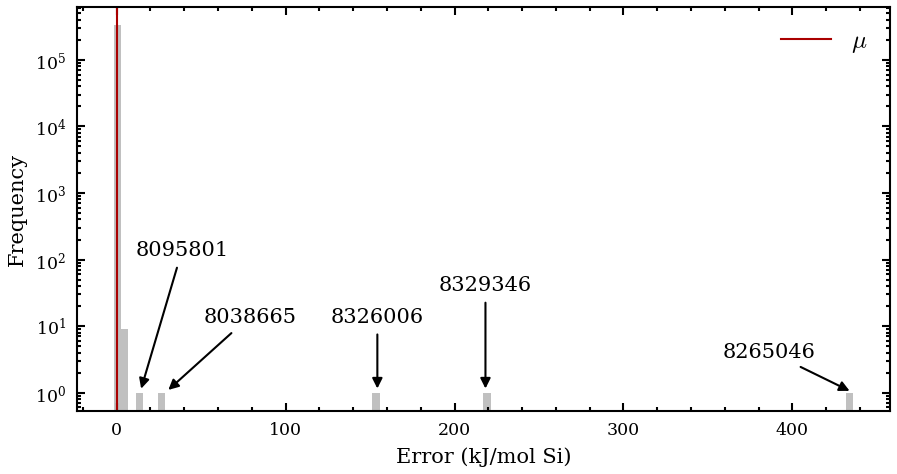

In [28]:
fig = plt.figure(figsize=(7.0, 3.5))
axs = fig.add_subplot(1, 1, 1)

axs.hist(errors_330k_energies, density=False, bins=100, log=True, facecolor='silver')

axs.axvline(mean_errors_330k_energies, color=color_list[1], label=r'$\mu$')

#for idx, i in enumerate(range(1, 6, 2)):
#     axs.axvline(mean_errors_330k_energies + i * stdev_errors_330k_energies, 
#                 linestyle=line_list[idx], label=r'$\pm$' + f'{i}' + r'$\sigma$')
#     axs.axvline(mean_errors_330k_energies - i * stdev_errors_330k_energies, 
#                 linestyle=line_list[idx])

axs.set_xlabel('Error (kJ/mol Si)')
axs.set_ylabel('Frequency')

axs.legend(fontsize='large')

annotate_params = dict(horizontalalignment='center', verticalalignment='bottom',
                       arrowprops=dict(arrowstyle='-|>'))

axs.annotate('8265046', (errors_330k_energies[265045], 1),
            xytext=(errors_330k_energies[265045]-50, 3),
            **annotate_params)
axs.annotate('8329346', (errors_330k_energies[329345], 1),
            xytext=(errors_330k_energies[329345], 30),
            **annotate_params)
axs.annotate('8326006', (errors_330k_energies[326005], 1),
            xytext=(errors_330k_energies[326005], 10),
            **annotate_params)
axs.annotate('8038665', (errors_330k_energies[38664], 1),
            xytext=(errors_330k_energies[38664]+50, 10),
            **annotate_params)
axs.annotate('8095801', (errors_330k_energies[95800], 1),
            xytext=(errors_330k_energies[95800]+25, 100),
            **annotate_params)
             
fig.savefig('../Results/gulp_error_histogram.pdf', bbox_inches='tight')
    
plt.show()

# Checks on geometry optimization

In [29]:
# TODO: eliminate RWY and the 5 deem structures

In [30]:
# Load indices of optimized structures
idxs_opt = np.loadtxt('../Processed_Data/Models/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/GCH/rattled/vlist.idx', dtype=int)
n_iza = 225
idxs_opt = idxs_opt[idxs_opt >= n_iza] - n_iza

In [31]:
idxs_deem_train = np.sort(np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int))
idxs_iza_train = np.sort(np.loadtxt('../Processed_Data/IZA_226/train.idxs', dtype=int))

In [32]:
cantons_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0][0]

In [33]:
deem_delete = np.loadtxt('../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)
deem_ids = np.arange(0, 331172)
deem_ids = np.delete(deem_ids, deem_delete) + 8000001

In [34]:
# Load old SOAPs
old_soaps_deem_file = h5py.File('../Processed_Data/DEEM_330k/Data/6.0/soaps_power_full_avg_nonorm.hdf5', 'r')
old_soaps_deem = old_soaps_deem_file['0'][idxs_deem_train, :]
old_soaps_deem_opt = old_soaps_deem_file['0'][idxs_opt, :]
old_soaps_deem_file.close()

old_soaps_iza = utils.load_structures_from_hdf5('../Processed_Data/IZA_226/Data/6.0/soaps_power_full_avg_nonorm.hdf5',
                                                datasets=None, concatenate=True)
old_soaps_iza = np.delete(old_soaps_iza, RWY, axis=0)
old_soaps_iza = old_soaps_iza[idxs_iza_train]

old_soaps = np.vstack((old_soaps_iza, old_soaps_deem))

In [35]:
# Load old decision functions
old_df = np.loadtxt('../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')[idxs_opt, :]
old_cantons = np.loadtxt('../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_cantons.dat', dtype=int)[idxs_opt]

In [63]:
# Load corresponding xyz
cif_glob = sorted(glob.glob('../Raw_Data/GULP/DEEM_330k/Geometry/8*/*_opt.cif'))
orig_cif_glob = [s.replace('Geometry/', '') for s in cif_glob]

deem_opt = [read(cif_file, format='cif') for cif_file in cif_glob]
deem_orig = [read(cif_file, format='cif') for cif_file in orig_cif_glob]

In [66]:
# Large numbers likely due to the 0/1 cell boundary
for opt, orig, glob in zip(deem_opt, deem_orig, orig_cif_glob):
    print(os.path.basename(glob), distance(opt, orig))

8129307_opt.cif 0.005578273140481637
8129502_opt.cif 23.256612886185803
8154451_opt.cif 0.016386181675007588
8162067_opt.cif 0.0010614732815458336
8171809_opt.cif 0.005712884170824324
8286860_opt.cif 0.003068503597901241
8301971_opt.cif 0.0030227870219129453


In [37]:
opt_soaps = librascal_soap(deem_opt, [14],
                           **soap_hyperparameters,
                           normalize=False, 
                           average=True, 
                           concatenate=True)

100%|██████████| 7/7 [00:00<00:00, 85.26it/s]


In [38]:
print(np.linalg.norm(opt_soaps - old_soaps_deem_opt, axis=1))

[1.63085554e-06 7.37870407e-07 7.52730881e-07 2.45267341e-07
 1.07735862e-06 1.34693209e-07 1.77601459e-07]


In [39]:
soap_scale = np.std(old_soaps)

lsvc = LinearSVC()
lsvc_dict = load_json('../Processed_Data/Models/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc.json', array_convert=True)
lsvc.__dict__ = lsvc_dict

opt_df = lsvc.decision_function(opt_soaps / soap_scale)
opt_cantons = lsvc.predict(opt_soaps / soap_scale)

In [40]:
opt_df

array([[ -3.43832451, -10.28983252,  -8.02390094,   4.11378737],
       [ -6.2380323 ,  -5.30778473,  -3.14313988,   2.93446246],
       [ -4.64386883, -12.86502215,  -9.81393548,   6.89819009],
       [ -6.52820209,  -5.710208  ,  -2.00586572,   0.19344744],
       [ -5.89627736, -17.98955797,  -7.07448019,   6.19365991],
       [ -3.2686013 ,  -3.32880773,  -8.45304135,   3.30751157],
       [ -4.19626375,  -2.36694088,  -5.17583915,   0.76675821]])

In [41]:
old_df

array([[ -3.60330169, -10.78943244,  -8.40059917,   4.32851384],
       [ -6.51514771,  -5.53944611,  -3.27410005,   3.06077119],
       [ -4.84927237, -13.43976356, -10.25483399,   7.21259196],
       [ -6.80901789,  -5.95515394,  -2.09624478,   0.20685544],
       [ -6.14058224, -18.79316499,  -7.40798185,   6.48128434],
       [ -3.40779344,  -3.46982879,  -8.81643724,   3.45102412],
       [ -4.37463058,  -2.47206854,  -5.40254089,   0.80355065]])

In [67]:
print((opt_df - old_df) / old_df * 100)

[[-4.57850025 -4.63045596 -4.48418286 -4.96074351]
 [-4.25340178 -4.18203136 -3.99988301 -4.12669628]
 [-4.23576    -4.276425   -4.29942124 -4.35906925]
 [-4.12417484 -4.11317559 -4.31147445 -6.48182047]
 [-3.97852958 -4.27606003 -4.50192321 -4.43776904]
 [-4.08452404 -4.0642082  -4.12179975 -4.15854971]
 [-4.07730021 -4.25261917 -4.19620591 -4.57873278]]


In [42]:
print(np.linalg.norm(opt_df - old_df, axis=1))
for idx, i in enumerate(idxs_opt):
    print(deem_ids[i], opt_cantons[idx], old_cantons[idx])

[0.6817819  0.40443096 0.81594016 0.38367196 0.94837771 0.43807969
 0.30921499]
8129309 4 4
8129504 4 4
8154453 4 4
8162069 4 4
8171811 4 4
8286863 4 4
8301974 4 4


# Find IZA in DEEM 330k

In [93]:
labels_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=0, dtype='3U')
RWY = np.nonzero(labels_iza == 'RWY')[0][0]
labels_iza = np.delete(labels_iza, RWY)

In [94]:
# Load old SOAPs
deem_soaps_file = h5py.File('../Processed_Data/DEEM_330k/Data/6.0/soaps_power_full_avg_nonorm.hdf5', 'r')
deem_soaps = deem_soaps_file['0']

iza_soaps = utils.load_structures_from_hdf5('../Processed_Data/IZA_226/Data/6.0/soaps_power_full_avg_nonorm.hdf5',
                                                datasets=None, concatenate=True)
iza_soaps = np.delete(iza_soaps, RWY, axis=0)

In [95]:
batch_size = 10000
n_samples_330k = deem_soaps.len()
n_batches = n_samples_330k // batch_size
if n_samples_330k % batch_size > 0:
    n_batches += 1

In [96]:
D = []
for i in tqdm(range(0, n_batches)):
    D.append(np.sqrt(sqeuclidean_distances(deem_soaps[i*batch_size:(i+1)*batch_size, :], iza_soaps)))
    
D = np.vstack(D)

In [97]:
deem_soaps_file.close()

In [98]:
logD = np.log10(D)
logDmin = np.log10(np.amin(D, axis=0))

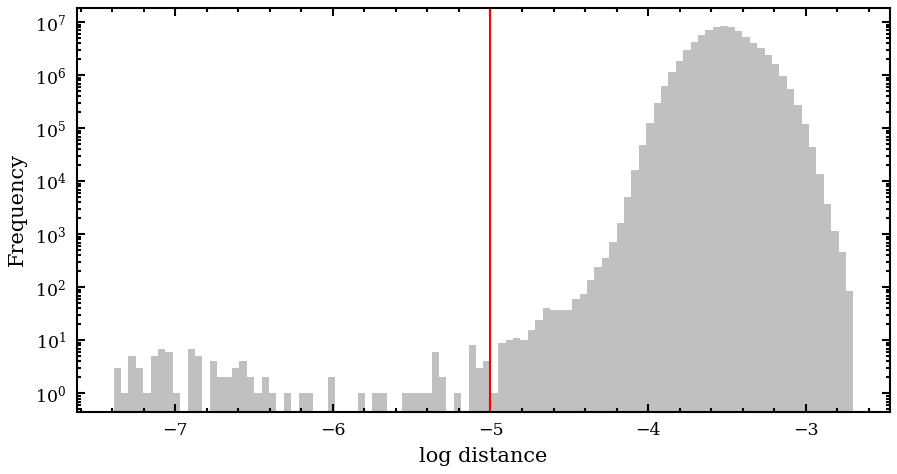

In [99]:
fig = plt.figure(figsize=(7.0, 3.5))
axs = fig.add_subplot(1, 1, 1)

axs.hist(logD.flatten(), density=False, bins=100, log=True, facecolor='silver')
#axs.hist(logDmin, density=False, bins=100, log=True, facecolor='silver')
#axs.set_xscale('log')
axs.axvline(-5, color='r')

axs.set_xlabel('log distance')
axs.set_ylabel('Frequency')
    
plt.show()

In [106]:
deem_idxs, iza_idxs = np.nonzero(logD <= -6)

In [107]:
print(labels_iza[sorted(iza_idxs)])

['AEI' 'AFR' 'AFS' 'AFT' 'AFV' 'AFX' 'AFY' 'ANA' 'ASV' 'AVE' 'AVL' 'AWW'
 'BEC' 'BOG' 'BPH' 'CHA' 'EAB' 'EMT' 'ERI' 'ESV' 'ETR' 'EZT' 'FAU' 'FER'
 'FRA' 'GIS' 'GME' 'GON' 'GOO' 'HEU' 'IFO' 'IFY' 'ISV' 'ITE' 'IWR' 'IWV'
 'KFI' 'LEV' 'LTJ' 'LTL' 'MAZ' 'MEI' 'MEL' 'MOR' 'MRT' 'MSO' 'NES' 'OFF'
 'PHI' 'PON' 'POR' 'POS' 'RHO' 'RTE' 'SAF' 'SAO' 'SAS' 'SAV' 'SBE' 'SBS'
 'SFW' 'SIV' 'STI' 'STW' 'SWY' 'TSC' 'UEI' 'UOZ' 'ZON']


# Load DEEM_10k

In [ ]:
# Load DEEM 10k
deem_10k = read('../Raw_Data/DEEM_10k/DEEM_10000.xyz', index=':')

In [ ]:
# Extract energies per Si atom
deem_10k_volumes = []
deem_10k_energies = []
n_Si = []

for structure in deem_10k:
    Z = structure.get_atomic_numbers()
    n_Si.append(np.count_nonzero(Z == 14))
    deem_10k_volumes.append(structure.cell.volume / n_Si[-1])
    deem_10k_energies.append(structure.info['Energy_per_Si'])
    
deem_10k_volumes = np.asarray(deem_10k_volumes)
deem_10k_energies = np.asarray(deem_10k_energies)

# Check DEEM database energies vs. GULP geometry optimizations for the 10k structure subset

In [ ]:
# Load GULP energies, which are in the same order as the loaded structures
deem_10k_energies_gulp = np.loadtxt('../Raw_Data/GULP/DEEM_10k/Energies_DEEM.dat', usecols=8)

# Check that GULP energies are similar to the database energies
abs_err = np.abs(deem_10k_energies - deem_10k_energies_gulp)

# mean, median, and maximum absolute error
print(np.mean(abs_err))
print(np.median(abs_err))
print(np.amax(abs_err))

# Truncate DEEM dataset for testing

In [ ]:
n = 2000
stride = len(deem_10k) // n
structures = deem_10k[::stride]
structure_volumes = deem_10k_volumes[::stride]
structure_energies = deem_10k_energies[::stride]
print(len(structures))

In [ ]:
f = 0.75
idxs = np.arange(0, len(structures))
np.random.shuffle(idxs)
train_idxs = idxs[0:int(n*f)]
test_idxs = idxs[int(n*f):]

# Test FPS on environment SOAPs vs. FPS on mean SOAPs

In [ ]:
# Compute environment SOAPs
soaps = librascal_soap(structures, [14],
                         **soap_hyperparameters)

In [ ]:
# Compute avg SOAPs
soaps_avg = librascal_soap(structures, [14],
                              **soap_hyperparameters,
                              average=True)
soaps_avg = np.asarray(soaps_avg)

In [ ]:
n_components = 500

In [ ]:
# FPS on environment SOAPs
fps, _ = FPS(np.concatenate([soaps[i] for i in train_idxs], axis=0).T, n=n_components, start=0)
print(fps.size)

In [ ]:
# FPS on average SOAPs
fps_avg, _ = FPS(soaps_avg[train_idxs, :].T, n=n_components, start=0)
print(fps_avg.size)

In [ ]:
print(len(np.setdiff1d(fps, fps_avg)))
print(len(np.setdiff1d(fps_avg, fps)))

# Truncate the SOAPs

In [ ]:
soaps_avg = [soap[:, fps_avg] for soap in soaps]
soaps = [soap[:, fps] for soap in soaps]

In [ ]:
print(np.concatenate(soaps, axis=0).shape)
print(np.concatenate(soaps_avg, axis=0).shape)

# Get representative environments

In [ ]:
n_representatives = 2000
representatives, _ = FPS(np.concatenate([soaps[i] for i in train_idxs], axis=0), n=n_representatives)
representatives_avg, _ = FPS(np.concatenate([soaps_avg[i] for i in train_idxs], axis=0), n=n_representatives)

In [ ]:
soaps_rep = np.concatenate([soaps[i] for i in train_idxs], axis=0)[representatives, :]
soaps_rep_avg = np.concatenate([soaps_avg[i] for i in train_idxs], axis=0)[representatives_avg, :]

In [ ]:
print(soaps_rep.shape)
print(soaps_rep_avg.shape)

# Center properties and build kernels

In [ ]:
# Center properties
avg_volume = np.mean(structure_volumes[train_idxs])
avg_energy = np.mean(structure_energies[train_idxs])

structure_volumes -= avg_volume
structure_energies -= avg_energy

In [ ]:
# Build sparse linear kernels
zeta = 1
KMM_linear = build_kernel(soaps_rep, soaps_rep,
                         kernel='linear', zeta=zeta)
KNM_train_linear = build_kernel([soaps[i] for i in train_idxs], soaps_rep, 
                                kernel='linear', zeta=zeta)
KNM_test_linear = build_kernel([soaps[i] for i in test_idxs], soaps_rep, 
                               kernel='linear', zeta=zeta)

KMM_linear_avg = build_kernel(soaps_rep_avg, soaps_rep_avg,
                             kernel='linear', zeta=zeta)
KNM_train_linear_avg = build_kernel([soaps_avg[i] for i in train_idxs], soaps_rep_avg, 
                                    kernel='linear', zeta=zeta)
KNM_test_linear_avg = build_kernel([soaps_avg[i] for i in test_idxs], soaps_rep_avg, 
                                   kernel='linear', zeta=zeta)

In [ ]:
# Build sparse Gaussian kernels
gamma = 0.5
KMM_gaussian = build_kernel(soaps_rep, soaps_rep,
                           kernel='gaussian', gamma=gamma)
KNM_train_gaussian = build_kernel([soaps[i] for i in train_idxs], soaps_rep, 
                                  kernel='gaussian', gamma=gamma)
KNM_test_gaussian = build_kernel([soaps[i] for i in test_idxs], soaps_rep, 
                                 kernel='gaussian', gamma=gamma)

KMM_gaussian_avg = build_kernel(soaps_rep_avg, soaps_rep_avg,
                               kernel='gaussian', gamma=gamma)
KNM_train_gaussian_avg = build_kernel([soaps_avg[i] for i in train_idxs], soaps_rep_avg, 
                                      kernel='gaussian', gamma=gamma)
KNM_test_gaussian_avg = build_kernel([soaps_avg[i] for i in test_idxs], soaps_rep_avg, 
                                     kernel='gaussian', gamma=gamma)

# Kernel speed

In [ ]:
K = build_kernel(soaps_rep, soaps_rep, kernel='gaussian', gamma=1.0)

In [ ]:
%%timeit
build_kernel(soaps_rep, soaps_rep, kernel='gaussian', gamma=3.0)

In [ ]:
%%timeit
K**3.0

In [ ]:
print(build_kernel(soaps_rep, soaps_rep, kernel='gaussian', gamma=3.0))
print(K**3.0)

# Volume regression

## Linear

In [ ]:
# SOAPs
sigma = 0.1**2
delta = np.var(structure_volumes[train_idxs])*KMM_linear.shape[0]/np.trace(KMM_linear)

skrr = SparseKRR(sigma=sigma, reg=1.0E-1)
skrr.fit(KNM_train_linear*delta, KMM_linear*delta, structure_volumes[train_idxs]*delta)
predicted_volumes = skrr.transform(KNM_test_linear)
print(np.mean(np.abs(structure_volumes[test_idxs] - predicted_volumes)))

In [ ]:
# Avg SOAPs with avg FPS
sigma = 0.1**2
delta = np.var(structure_volumes[train_idxs])*KMM_linear_avg.shape[0]/np.trace(KMM_linear_avg)

skrr_avg = SparseKRR(sigma=sigma, reg=1.0E-1)
skrr_avg.fit(KNM_train_linear_avg*delta, KMM_linear_avg*delta, structure_volumes[train_idxs]*delta)
predicted_volumes_avg = skrr_avg.transform(KNM_test_linear_avg)
print(np.mean(np.abs(structure_volumes[test_idxs] - predicted_volumes_avg)))

## Gaussian

In [ ]:
# SOAPs
sigma = 0.1**2
delta = np.var(structure_volumes[train_idxs])*KMM_gaussian.shape[0]/np.trace(KMM_gaussian)

skrr = SparseKRR(sigma=sigma, reg=1.0E-1)
skrr.fit(KNM_train_gaussian*delta, KMM_gaussian*delta, structure_volumes[train_idxs]*delta)
predicted_volumes = skrr.transform(KNM_test_gaussian)
print(np.mean(np.abs(structure_volumes[test_idxs] - predicted_volumes)))

In [ ]:
# Avg SOAPs with avg FPS
sigma = 0.1**2
delta = np.var(structure_volumes[train_idxs])*KMM_gaussian_avg.shape[0]/np.trace(KMM_gaussian_avg)

skrr_avg = SparseKRR(sigma=sigma, reg=1.0E-1)
skrr_avg.fit(KNM_train_gaussian_avg*delta, KMM_gaussian_avg*delta, structure_volumes[train_idxs]*delta)
predicted_volumes_avg = skrr_avg.transform(KNM_test_gaussian_avg)
print(np.mean(np.abs(structure_volumes[test_idxs] - predicted_volumes_avg)))

# Energy regression

## Linear

In [ ]:
# SOAPs
sigma = 0.01**2
delta = np.var(structure_energies[train_idxs])*KMM_linear.shape[0]/np.trace(KMM_linear)

skrr = SparseKRR(sigma=sigma, reg=1.0E-3)
skrr.fit(KNM_train_linear*delta, KMM_linear*delta, structure_energies[train_idxs]*delta)
predicted_energies = skrr.transform(KNM_test_linear)
print(np.mean(np.abs(structure_energies[test_idxs] - predicted_energies)))

In [ ]:
# Avg SOAPs with avg FPS
sigma = 0.01**2
delta = np.var(structure_energies[train_idxs])*KMM_linear_avg.shape[0]/np.trace(KMM_linear_avg)

skrr_avg = SparseKRR(sigma=sigma, reg=1.0E-3)
skrr_avg.fit(KNM_train_linear_avg*delta, KMM_linear_avg*delta, structure_energies[train_idxs]*delta)
predicted_energies_avg = skrr_avg.transform(KNM_test_linear_avg)
print(np.mean(np.abs(structure_energies[test_idxs] - predicted_energies_avg)))

## Gaussian

In [ ]:
# SOAPs
sigma = 0.01**2
delta = np.var(structure_energies[train_idxs])*KMM_gaussian.shape[0]/np.trace(KMM_gaussian)

skrr = SparseKRR(sigma=sigma, reg=1.0E-3)
skrr.fit(KNM_train_gaussian*delta, KMM_gaussian*delta, structure_energies[train_idxs]*delta)
predicted_energies = skrr.transform(KNM_test_gaussian)
print(np.mean(np.abs(structure_energies[test_idxs] - predicted_energies)))

In [ ]:
# Avg SOAPs with avg FPS
sigma = 0.01**2
delta = np.var(structure_energies[train_idxs])*KMM_gaussian_avg.shape[0]/np.trace(KMM_gaussian_avg)

skrr_avg = SparseKRR(sigma=sigma, reg=1.0E-3)
skrr_avg.fit(KNM_train_gaussian_avg*delta, KMM_gaussian_avg*delta, structure_energies[train_idxs]*delta)
predicted_energies_avg = skrr_avg.transform(KNM_test_gaussian_avg)
print(np.mean(np.abs(structure_energies[test_idxs] - predicted_energies_avg)))

# Distance computation

In [ ]:
# Build some large matrices
XA = np.random.random_sample(size=(10000, 500))
XB = np.random.random_sample(size=(10000, 500))

## cdist

In [ ]:
%%timeit
D = cdist(XA, XB, metric='sqeuclidean')

In [ ]:
%%timeit
D = cdist(XA, XB, metric='euclidean')**2

In [ ]:
D = cdist(XA, XB, metric='sqeuclidean')
print(D)

In [ ]:
D = cdist(XA, XB, metric='euclidean')**2
print(D)

## pairwise_distances

In [ ]:
%%timeit
D = pairwise_distances(XA, XB, metric='sqeuclidean', n_jobs=-1)

In [ ]:
%%timeit
D = pairwise_distances(XA, XB, metric='sqeuclidean')

In [ ]:
%%timeit
D = pairwise_distances(XA, XB, metric='euclidean', n_jobs=-1)**2

In [ ]:
%%timeit
D = pairwise_distances(XA, XB, metric='euclidean')**2

In [ ]:
D = pairwise_distances(XA, XB, metric='sqeuclidean', n_jobs=-1)
print(D)

In [ ]:
D = pairwise_distances(XA, XB, metric='sqeuclidean')
print(D)

In [ ]:
D = pairwise_distances(XA, XB, metric='euclidean', n_jobs=-1)**2
print(D)

In [ ]:
D = pairwise_distances(XA, XB, metric='euclidean')**2
print(D)

## Multiprocessing (unusably slow)

## Faster squared euclidean distance

In [ ]:
def sqeuclidean_distance(XA, XB):
    XA2 = np.sum(XA**2, axis=1).reshape((-1, 1))
    XB2 = np.sum(XB**2, axis=1).reshape((1, -1))
    D = XA2 + XB2 - 2*np.matmul(XA, XB.T)
    return D

In [ ]:
%%timeit
D = sqeuclidean_distance(XA, XB)

In [ ]:
D = sqeuclidean_distance(XA, XB)
print(D)

# Kernel Computation

## Multiprocessing

In [ ]:
# Gaussian kernel with cdist
def g_kernel_cdist(XA, XB, gamma=1.0, row_mean=True, col_mean=True):
    K = cdist(XA, XB, metric='sqeuclidean')
    K = np.exp(-gamma*K)
    
    if row_mean and col_mean:
        K = np.mean(K)
    elif row_mean:
        K = np.mean(K, axis=0)
    elif col_mean:
        K = np.mean(K, axis=1)
        
    return K

# Gaussian kernel pairwise_distances
def g_kernel_pairwise(XA, XB, gamma=1.0, row_mean=True, col_mean=True):
    K = pairwise_distances(XA, XB, metric='euclidean')**2
    K = np.exp(-gamma*K)
    
    if row_mean and col_mean:
        K = np.mean(K)
    elif row_mean:
        K = np.mean(K, axis=0)
    elif col_mean:
        K = np.mean(K, axis=1)
        
    return K

In [ ]:
# Build some large matrices
XA = np.random.random_sample(size=(10000, 500))
XB = np.random.random_sample(size=(10000, 500))

XA /= 500
XB /= 500

In [ ]:
split_A = np.random.randint(0, 10000, 100)
split_B = np.random.randint(0, 10000, 100)

split_A.sort()
split_B.sort()

In [ ]:
XA = np.split(XA, split_A)
XB = np.split(XB, split_B)

XA = [xa for xa in XA if xa.size > 0]
XB = [xb for xb in XB if xb.size > 0]

In [ ]:
%%timeit
with multiprocessing.Pool() as pool:
    out = pool.starmap(g_kernel_cdist, itertools.product(XA, XB))

np.reshape(out, (len(XA), len(XB)))

In [ ]:
%%timeit
with multiprocessing.Pool() as pool:
    out = pool.starmap(g_kernel_pairwise, itertools.product(XA, XB))
    
np.reshape(out, (len(XA), len(XB)))

In [ ]:
%%timeit
build_kernel(XA, XB, kernel='gaussian', gamma=1.0) # 8s with sklearn

In [ ]:
with multiprocessing.Pool() as pool:
    out = pool.starmap(g_kernel_cdist, itertools.product(XA, XB))

out = np.reshape(out, (len(XA), len(XB)))
print(out)

In [ ]:
with multiprocessing.Pool() as pool:
    out = pool.starmap(g_kernel_pairwise, itertools.product(XA, XB))

out = np.reshape(out, (len(XA), len(XB)))
print(out)

In [ ]:
out = build_kernel(XA, XB, kernel='gaussian', gamma=1.0)
print(out)